# Topic Modeling on Security Conferences
### Files needed
1. Reads files from the folders /abstracts and /authors
2. Reads LDA Mallet model from the folder /mallet-2.0.8
### 

In [70]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Imports and read file to corpus

In [92]:
import nltk
import gensim
import re
from gensim import corpora
from gensim.parsing.preprocessing import *
from gensim.models import CoherenceModel
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
#nltk.download('stopwords')      # If this code block complains, comment out this line
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')
from nltk.corpus import stopwords
import pyLDAvis.gensim
import numpy as np
import os
from pprint import pprint
# Figures
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

os.environ['MALLET_HOME']='mallet-2.0.8'
mallet_path = 'mallet-2.0.8/bin/mallet'

In [68]:
def readFile(filename):
    fileData = ""
    file = open("abstracts/" + filename, 'r', encoding='utf8')
    fileData = file.read().splitlines()
    file.close
    return fileData

In [69]:
corpus = []


for i in range (2012,2020):
    conference = readFile('usenix' + str(i) + 'Abstracts.txt')
    for abstract in conference:
        corpus.append(abstract)
for i in range (2011,2020):
    conference = readFile('css' + str(i) + 'Abstracts.txt')
    for abstract in conference:
        corpus.append(abstract)
for i in range (2000,2020):
    conference = readFile('ieee' + str(i) + 'Abstracts.txt')
    for abstract in conference:
        corpus.append(abstract)
for i in range (2012,2020):
    conference = readFile('ndss' + str(i) + 'Abstracts.txt')
    for abstract in conference:
        corpus.append(abstract)
        
#print(corpus)
len(corpus)

3694

## Preprocessing of the corpus
Preprocess the raw corpues into a list of words for each document

In [71]:
lemmatizer = WordNetLemmatizer()

# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            # lemmatized_sentence.append(word)
            pass# This part is modified so that we will just have ADJ VERB NOUN ADVERB remained 
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [72]:
CUSTOM_FILTERS = [
    strip_tags,                            # Remove HTML tags and such
    strip_punctuation,                     # Remove punctuation
    strip_multiple_whitespaces,            # Remove unecessary space and such
    strip_numeric,                         # Remove numbers
    lambda x: strip_short(x, 4),           # Remove words shorter than 2 chars
    lambda y: y.replace('“', ''),          # Removes quation marks
    lambda z: z.replace('”', ''),          # Removes quation marks
    lambda a: a.lower(),                   # Makes the corpus lowercase
    lambda z: remove_stopwords(z)          # Removes stopwords 
]

def clean_doc(doc):
    lematized_doc = lemmatize_sentence(doc)
    cleanDoc = preprocess_string(lematized_doc, CUSTOM_FILTERS)
    return cleanDoc

corpus_clean = [clean_doc(doc) for doc in corpus]

### Contiune the preprocessing, now with the list of words. Creating bigrams

In [73]:
bigram = gensim.models.Phrases(corpus_clean, min_count=5, threshold=100) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram)

def make_bigrams(corpus):
    return [bigram_mod[doc] for doc in corpus]

corpus_clean_bigram = make_bigrams(corpus_clean)

### Splitting the corpus and making it into a dictionary

In [74]:
dictionary = corpora.Dictionary(corpus_clean_bigram)
M1 = [dictionary.doc2bow(doc) for doc in corpus_clean_bigram]

### Making the tfidf model
Not in use for LDA Mallet

In [76]:
tfidf_model = gensim.models.TfidfModel(M1)
tfidf_M1 = tfidf_model[M1]
#print(tfidf_model)
#print(tfidf_M1)
#print(M1)

## Finding optimal number of topics
Machinelearingplus.com approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.

If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

The compute_coherence_values() (see below) trains multiple LDA models and provides the models and their corresponding coherence scores.

In [78]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

        print(num_topics)
        
    return model_list, coherence_values

### Coherence score over topics, Stepping every 4th
Stepping from 2 to 104 with a step length of 4

In [79]:
# Can take a long time to run
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=M1, texts=corpus_clean_bigram, limit=104, start=2, step=4)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69


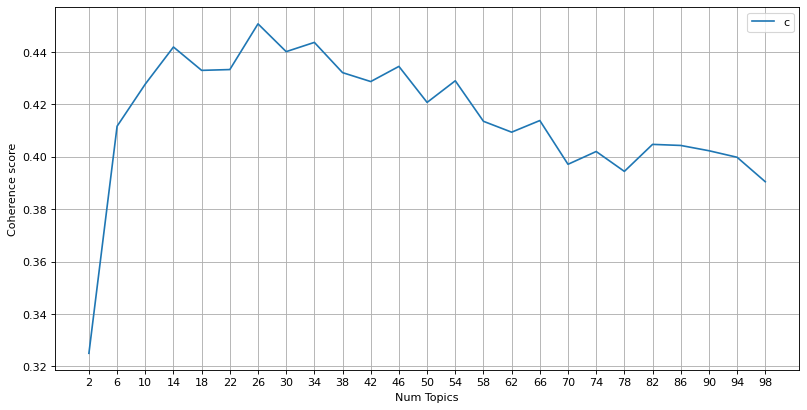

In [97]:
coherence_values = [0.3250157403264292, 0.4116900808150424, 0.4277707176143622, 0.4419215919328382, 0.43300547700202796, 0.43331531510788773, 0.4507613241261437, 0.4401537362798364, 0.4436828004648704, 0.4321437701507225, 0.4287353256235635, 0.4345214971377863, 0.4207751964079457, 0.42903262376408574, 0.41356412264891634, 0.4094172711686478, 0.41385811506381215, 0.3971588021061537, 0.4020413137080951, 0.3944484660319797, 0.40475857425077855, 0.4043484985706639, 0.40233617235048474, 0.39983668071530726, 0.39050519443737175]
figure(figsize=(12, 6), dpi=80)
# Show graph
limit=102; start=2; step=4;
x = range(start, limit, step)
xi = list(x)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.xticks(xi, x)
plt.legend(("coherence_values"), loc='best')
plt.grid(True)
plt.show()

In [98]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.325
Num Topics = 6  has Coherence Value of 0.4117
Num Topics = 10  has Coherence Value of 0.4278
Num Topics = 14  has Coherence Value of 0.4419
Num Topics = 18  has Coherence Value of 0.433
Num Topics = 22  has Coherence Value of 0.4333
Num Topics = 26  has Coherence Value of 0.4508
Num Topics = 30  has Coherence Value of 0.4402
Num Topics = 34  has Coherence Value of 0.4437
Num Topics = 38  has Coherence Value of 0.4321
Num Topics = 42  has Coherence Value of 0.4287
Num Topics = 46  has Coherence Value of 0.4345
Num Topics = 50  has Coherence Value of 0.4208
Num Topics = 54  has Coherence Value of 0.429
Num Topics = 58  has Coherence Value of 0.4136
Num Topics = 62  has Coherence Value of 0.4094
Num Topics = 66  has Coherence Value of 0.4139
Num Topics = 70  has Coherence Value of 0.3972
Num Topics = 74  has Coherence Value of 0.402
Num Topics = 78  has Coherence Value of 0.3944
Num Topics = 82  has Coherence Value of 0.4048
Num Topics = 86  ha

#### Result
This gives us the top highest coherence score:
- Num Topics = 26  has Coherence Value of 0.4508

### Coherence score over topics, Stepping every one
Now we want to be more exact but since the coherence is dropping with higher number of topics we reduce the upper limit.

Now we try to step from 2 to 70 on every value

In [ ]:
# Can take a long time to run
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=M1, texts=corpus_clean_bigram, limit=70, start=2, step=1)

In [90]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3257
Num Topics = 3  has Coherence Value of 0.3537
Num Topics = 4  has Coherence Value of 0.3859
Num Topics = 5  has Coherence Value of 0.3938
Num Topics = 6  has Coherence Value of 0.3968
Num Topics = 7  has Coherence Value of 0.4085
Num Topics = 8  has Coherence Value of 0.4213
Num Topics = 9  has Coherence Value of 0.419
Num Topics = 10  has Coherence Value of 0.428
Num Topics = 11  has Coherence Value of 0.4309
Num Topics = 12  has Coherence Value of 0.4236
Num Topics = 13  has Coherence Value of 0.4517
Num Topics = 14  has Coherence Value of 0.4423
Num Topics = 15  has Coherence Value of 0.4296
Num Topics = 16  has Coherence Value of 0.4313
Num Topics = 17  has Coherence Value of 0.4296
Num Topics = 18  has Coherence Value of 0.4301
Num Topics = 19  has Coherence Value of 0.436
Num Topics = 20  has Coherence Value of 0.4288
Num Topics = 21  has Coherence Value of 0.4311
Num Topics = 22  has Coherence Value of 0.451
Num Topics = 23  has Cohe

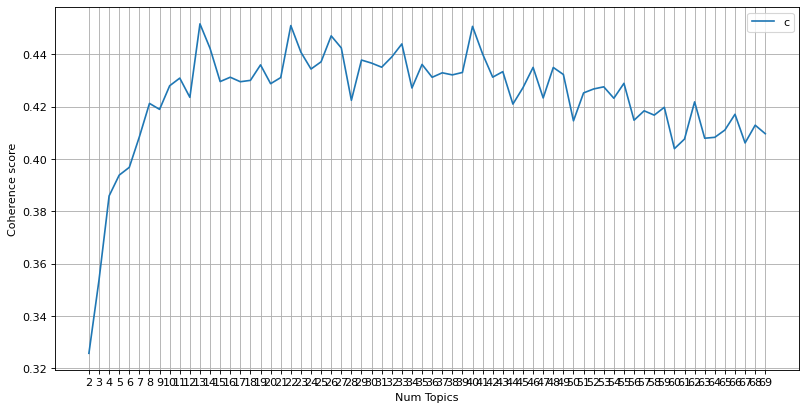

In [99]:
#coherence_values = [0.32571064083112744, 0.3537344947550003, 0.38589689375318126, 0.39384185450287246, 0.3968198253781281, 0.4085182731090585, 0.42127183913002364, 0.41899078263050016, 0.42801836357265693, 0.4309421068656622, 0.4235910756450276, 0.4516905876830981, 0.44230979084842603, 0.4296217041847969, 0.4312776000207533, 0.42955783914286844, 0.4300818857106711, 0.43599484572542013, 0.4288093062032049, 0.431145903679033, 0.45102550720523704, 0.4408525746026434, 0.43442023864813467, 0.437182271259546, 0.44709664105064434, 0.44248557145575135, 0.42246041004330903, 0.43784503147185494, 0.43667989244832234, 0.4351125576380536, 0.43902968092362493, 0.4440178347094399, 0.4271598549200618, 0.43617684419539876, 0.43125821112489443, 0.4329721336785587, 0.43217676681552086, 0.43310381516722185, 0.45072485690785824, 0.4401630451262257, 0.43130301356185136, 0.4334126436221655, 0.421009575540349, 0.4272964973804624, 0.4350421319148597, 0.4233540568965465, 0.4350122511003696, 0.43232603003979947, 0.41460403500831033, 0.42528017344333635, 0.4267933944574832, 0.4276083290805306, 0.4232434154417294, 0.4289482978832848, 0.4148342197092429, 0.4184389211956406, 0.4167830014416288, 0.41978178212929607, 0.40395936537564947, 0.40763329977423757, 0.421859133976826, 0.4079528877973058, 0.408300929971383, 0.41109076687251356, 0.4171141990155899, 0.40615382099134045, 0.4129390628617565, 0.40967900018905035]
figure(figsize=(12, 6), dpi=80)
# Show graph
limit=70; start=2; step=1;
x = range(start, limit, step)
xi = list(x)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.xticks(xi, x)
plt.legend(("coherence_values"), loc='best')
plt.grid(True)
plt.show()

#### Result
This gives us:
- Num Topics = 13  has Coherence Value of 0.4517
- Num Topics = 21  has Coherence Value of 0.4311
- Num Topics = 40  has Coherence Value of 0.4507

And one can see that we now have three good candidates in the number of topics

## LDA mallet
Reads the LDA mallet model from the folder /mallet-2.0.8

In [100]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path,
                                             corpus=M1,
                                             num_topics=13,
                                             id2word=dictionary)

In [101]:
# Show Topics
#pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, 
                                           texts=corpus_clean_bigram,
                                           dictionary=dictionary, 
                                           coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.4337925135908136


## Setting upp the lda model
Used insted of LDA mallet

In [26]:
Lda = gensim.models.ldamodel.LdaModel
lda_model = Lda(tfidf_M1, 
                num_topics=2, 
                id2word = dictionary, 
                passes=18, 
                random_state =0)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Multicore

In [27]:
Lda = gensim.models.ldamulticore.LdaMulticore
lda_model = Lda(tfidf_M1 , 
                num_topics=8, 
                id2word = dictionary, 
                passes=15,
                random_state =0,
                workers=4)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
coherence_model_lda = CoherenceModel(model=lda_model, 
                                     texts=corpus_clean_bigram, 
                                     dictionary=dictionary)
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Coherence Score:  0.6364102700593359


In [25]:
topics = lda_model.print_topics(num_topics=100, num_words=6)

for topic in topics:
    print(topic)

(0, '0.001*"abstract" + 0.001*"available" + 0.001*"flash" + 0.001*"rpki" + 0.001*"skimmer" + 0.001*"walkie_talkie"')
(1, '0.001*"helios" + 0.001*"prêt_voter" + 0.001*"volte" + 0.001*"coercion" + 0.001*"sanctum" + 0.001*"guis"')
(2, '0.002*"captchas" + 0.001*"rust" + 0.001*"captcha" + 0.001*"pill" + 0.001*"spurious" + 0.000*"macs"')
(3, '0.002*"workshop" + 0.001*"proverif" + 0.001*"quic" + 0.001*"meltdown" + 0.001*"protocol" + 0.001*"snarks"')
(4, '0.002*"rowhammer" + 0.001*"deduplication" + 0.001*"printer" + 0.001*"uninitialized" + 0.001*"spamming" + 0.001*"spammer"')
(5, '0.004*"attack" + 0.003*"user" + 0.003*"protocol" + 0.003*"data" + 0.003*"security" + 0.002*"network"')
(6, '0.001*"recommender" + 0.001*"bliss" + 0.001*"sdns" + 0.001*"journalist" + 0.000*"fake_visitations" + 0.000*"court"')
(7, '0.001*"vault" + 0.001*"crowdturfing" + 0.001*"fitness" + 0.001*"compartmentalization" + 0.001*"kerberos" + 0.001*"ethos"')


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Visualisation of topics
First creating a lda mallet model and then visualising

In [102]:
def mallet_to_lda(mallet_model):
    model_gensim = gensim.models.ldamodel.LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha, eta=0, iterations=1000,
        gamma_threshold=0.001,
        dtype=np.float32
    )
    model_gensim.sync_state()
    model_gensim.state.sstats = mallet_model.wordtopics
    return model_gensim

In [103]:
lda_mallet_model = mallet_to_lda(ldamallet)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_mallet_model, M1, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
1      0.020757  0.075658       1        1  7.939920
0      0.298472  0.028286       2        1  7.880070
4      0.047822 -0.026915       3        1  7.845906
5     -0.025047 -0.209582       4        1  7.758937
2     -0.039876 -0.075916       5        1  7.745698
8     -0.204833 -0.051947       6        1  7.667154
3      0.260653 -0.027851       7        1  7.651709
11    -0.162350 -0.063174       8        1  7.647245
12    -0.180157  0.231620       9        1  7.639369
6      0.029227 -0.052205      10        1  7.603827
10    -0.045729  0.227177      11        1  7.565858
7      0.054367  0.186327      12        1  7.551150
9     -0.053306 -0.241479      13        1  7.503156, topic_info=         Term         Freq        Total Category  logprob  loglift
200    attack  4894.000000  4894.000000  Default  30.0000  30.0000
196      user  3331.000000  3331.000000  Default  29.0000  29.0000
14       data  2987.000000  2987.000000  Default  28.0000  28.0000
297  security  4263.000000  4263.000000  Default  27.0000  27.0000
379   network  1866.000000  1866.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
136      case   200.220892   546.964655  Topic13  -4.8946   1.5849
246     state   206.081015   734.809603  Topic13  -4.8657   1.3185
42      paper   249.055256  2074.396595  Topic13  -4.6763   0.4701
927      type   184.593895   561.561541  Topic13  -4.9758   1.4773
491  software   195.337455   887.636541  Topic13  -4.9193   1.0760

[1018 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
4270      1  0.994445         absence
2365      1  1.001306        abstract
545       1  0.995648     abstraction
821       1  0.916449      abstractly
0         5  0.162579           abuse
...     ...       ...             ...
977       9  1.083844        wrapping
69        1  0.005253            year
69        2  0.987535            year
69       10  0.005253            year
2657      9  1.004149  zero_knowledge

[1501 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 5, 6, 3, 9, 4, 12, 13, 7, 11, 8, 10])

## Topics per document
One of the practical application of topic modeling is to determine what topic a given document is about.

To find that, we find the topic number that has the highest percentage contribution in that document.

The format_topics_sentences() function below nicely aggregates this information in a presentable table.



In [104]:
lda_mallet_model.get_document_topics(M1[1],minimum_probability=0)

[(0, 0.08479924),
 (1, 0.07676252),
 (2, 0.071187355),
 (3, 0.077819385),
 (4, 0.083127245),
 (5, 0.077929474),
 (6, 0.07643844),
 (7, 0.07562872),
 (8, 0.07560397),
 (9, 0.07187412),
 (10, 0.0730955),
 (11, 0.075483985),
 (12, 0.0802501)]

In [106]:
import pandas as pd

def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_mallet_model, corpus=M1, texts=corpus_clean_bigram)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,8.0,0.0819,"code, memory, software, flow, hardware, execut...","[online, sale, counterfeit, unauthorized, prod..."
1,1,0.0,0.0848,"security, study, research, domain, risk, threa...","[traditional, spam, detection, rely, content, ..."
2,2,0.0,0.0819,"security, study, research, domain, risk, threa...","[paper, quantify, effect, unsolicited, email, ..."
3,3,1.0,0.0838,"security, policy, provide, implementation, mod...","[explore, robustness, usability, moving, image..."
4,4,2.0,0.0843,"attack, attacker, channel, exploit, demonstrat...","[help, user, create, strong, text, based, pass..."
5,5,5.0,0.0852,"model, approach, malware, malicious, detect, m...","[provide, number, practical, technique, algori..."
6,6,0.0,0.0827,"security, study, research, domain, risk, threa...","[vulnerabilities, browser, extension, user, ri..."
7,7,12.0,0.0801,"protocol, secure, scheme, party, computation, ...","[browser, mediate, access, valuable, private, ..."
8,8,12.0,0.0806,"protocol, secure, scheme, party, computation, ...","[cryptographic, rely, secrecy, cryptographic, ..."
9,9,0.0,0.0802,"security, study, research, domain, risk, threa...","[brain, interface, increasingly, popular, gami..."


In [52]:
corpus[6]

'Vulnerabilities in browser extensions put users at risk by providing a way for website and network attackers to gain access to users’ private data and credentials. Extensions can also introduce vulnerabilities into the websites that they modify. In 2009, Google Chrome introduced a new extension platform with several features intended to prevent and mitigate extension vulnerabilities: strong isolation between websites and extensions, privilege separation within an extension, and an extension permission system. We performed a security review of 100 Chrome extensions and found 70 vulnerabilities across 40 extensions. Given these vulnerabilities, we evaluate how well each of the security mechanisms defends against extension vulnerabilities. We find that the mechanisms mostly succeed at preventing web attacks, but new security mechanisms are needed to protect users from network attacks on extensions, website metadata attacks on extensions, and vulnerabilities that extensions add to website

## Most representative document per topic
Sometimes just the topic keywords may not be enough to make sense of what a topic is about. So, to help with understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document.

In [107]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.1047,"security, study, research, domain, risk, threa...","[blockchain, technology, recently, receive, co..."
1,1.0,0.1088,"security, policy, provide, implementation, mod...","[core, technique, popular, proxy, based, circu..."
2,2.0,0.1076,"attack, attacker, channel, exploit, demonstrat...","[according, recent, research, motion_sensor, a..."
3,3.0,0.0946,"user, browser, password, authentication, study...","[develop, economic, model, offline, password, ..."
4,4.0,0.1071,"device, application, access, android, apps, mo...","[user, single, authoritative, source, request,..."


## Topic distribution across documents
Finally, we want to understand the volume and distribution of topics in order to judge how widely it was discussed. The below table exposes that information.

In [111]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,8.0,"code, memory, software, flow, hardware, execut...",610.0,0.1651
1.0,0.0,"security, study, research, domain, risk, threa...",592.0,0.1603
2.0,0.0,"security, study, research, domain, risk, threa...",314.0,0.0850
3.0,1.0,"security, policy, provide, implementation, mod...",204.0,0.0552
4.0,2.0,"attack, attacker, channel, exploit, demonstrat...",440.0,0.1191
...,...,...,...,...
3689.0,0.0,"security, study, research, domain, risk, threa...",NaN,NaN
3690.0,12.0,"protocol, secure, scheme, party, computation, ...",NaN,NaN
3691.0,1.0,"security, policy, provide, implementation, mod...",NaN,NaN
3692.0,1.0,"security, policy, provide, implementation, mod...",NaN,NaN
